## 必要なライブラリ

In [3]:
#import kazane
#import pydub
import wave
import scipy as sp
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch import nn
import tqdm
from scipy.io.wavfile import write
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## 必要な関数の定義

In [4]:
from torch.nn import functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def downsampling(waveform, dr):
    down_waveform = signal.resample(waveform, len(waveform)//dr, t=None, axis=0, window=None, domain='time')
    down_waveform = np.array(down_waveform, dtype=np.int16)
    return  down_waveform 

def sinc(waveform, ur):
    waveform = torch.tensor((waveform/ 32768).tolist()) 
    waveform.to(device)
    upsampler = kazane.Upsample(ur)
    waveform_bi = upsampler(waveform)
    waveform_bi = waveform_bi * 32768
    x_numpy = waveform_bi.to('cpu').detach().numpy()
    x_numpy = x_numpy.astype(np.int16)
    waveform_bicubic = x_numpy
    
    return waveform_bicubic

def bicubic(waveform):
    waveform = torch.tensor([[[(waveform / 32768)]]]) 
    waveform.to(device)
    waveform_bi = F.interpolate(waveform, (1,  2 * len(waveform[0][0][0])), mode='bicubic', align_corners=False)
    waveform_bi = (waveform_bi * 32768).to(torch.int16)
    x_numpy = waveform_bi.to('cpu').detach().numpy().reshape(-1)
    return x_numpy
    
    #return waveform_bicubic

# まとめてGPUでbicubic補完：あまり速くならない
def batch_bicubic(waveforms):
    waveforms = torch.tensor((waveforms / 32768).reshape((len(waveforms), 1, 1, -1)))
    waveforms.to(device)
    waveforms_bi = F.interpolate(waveforms, (1,  2 * len(waveforms[0][0][0])), mode='bicubic', align_corners=False)
    waveforms_bi = (waveforms_bi * 32768).to(torch.int16)
    x_numpy = waveforms_bi.to('cpu').detach().numpy().reshape((len(waveforms), -1))
    return x_numpy
    
# scipy を使った方法．速さは pytorch と同じくらい．
from scipy.interpolate import interp1d
def scipy_bicubic(waveform):
    xs = np.linspace(1, len(waveform), len(waveform))
    xs2 = np.linspace(1, len(waveform), 2 * len(waveform))
    f = interp1d(xs, waveform / 32768, kind='cubic')
    waveform_bi = f(xs2) * 32768
    return waveform_bi.astype(np.int16)

In [5]:
def make_dataset(LF_magnitude, HF_magnitude, time_size, train_data_size):
    lengths = [min(len(hf), len(lf)) for hf, lf in zip(HF_magnitude, LF_magnitude)]
    sp_size = len(LF_magnitude[0][0])
    ur = 2
    k = 0
    time_size = time_size
    shift = time_size//2
    tdata_size = train_data_size
    
    x_train = []
    for j, data in tqdm.tqdm(enumerate(LF_magnitude[0: tdata_size])):
        i = 0
        while i < lengths[j]-time_size:
            spg = data[i:i + time_size, 0:sp_size//ur]
            x_train.append(spg)
            i += shift
        if lengths[j] >= time_size:
            spg = data[lengths[j]-time_size:lengths[j], 0:sp_size//ur]
            x_train.append(spg) 

    y_train = []
    for j, data in tqdm.tqdm(enumerate(HF_magnitude[0: tdata_size])):
        i = 0
        while i < lengths[j]-time_size:
            spg = data[i:i + time_size, sp_size//ur:]
            y_train.append(spg)
            i += shift
        if lengths[j] >= time_size:
            spg = data[lengths[j]-time_size:lengths[j], sp_size//ur:]
            y_train.append(spg) 

    x_valid = []
    for jj, data in tqdm.tqdm(enumerate(LF_magnitude[tdata_size:])):
        j = tdata_size + jj
        i = 0
        while i < lengths[j]-time_size:
            spg = data[i:i + time_size, 0:sp_size//ur]
            x_valid.append(spg)
            i += shift
        if lengths[j] >= time_size:
            spg = data[lengths[j]-time_size:lengths[j], 0:sp_size//ur]
            x_valid.append(spg) 

    y_valid = []
    for jj, data in tqdm.tqdm(enumerate(HF_magnitude[tdata_size:])):
        j = tdata_size + jj
        i = 0
        while i < lengths[j]-time_size:
            spg = data[i:i + time_size, sp_size//ur:]
            y_valid.append(spg)
            i += shift
        if lengths[j] >= time_size:
            spg = data[lengths[j]-time_size:lengths[j], sp_size//ur:]
            y_valid.append(spg) 
    return x_train, y_train, x_valid, y_valid

In [6]:
def get_spectral(angle_a, abs_a):
    return abs_a * (np.cos(angle_a) + 1j * np.sin(angle_a))

In [7]:
def LSD(x, y):
    return (1/x.shape[0])*(((1/x.shape[1])*((x-y)**2).sum(axis=1)) ** 0.5).sum()

In [8]:
def pred_show_spectrogram(fname):
    netG.eval()
    nover = 64
    time_size = 64
    ur = 2
    sp_size = 129
    amp = 2 * np.sqrt(2)
    pred_spectral=[]
    with wave.open(fname) as wave_file:
        length = wave_file.getnframes()
        fs = wave_file.getframerate()
        x = wave_file.readframes(wave_file.getnframes())
        wav_x = np.frombuffer(x, dtype= "int16")
        #wav_x = bicubic(wav_x)#16000Hz
        f, t, Zxx = signal.stft(wav_x[:length], fs, nperseg=256, noverlap=nover)
        data = np.log(np.abs(Zxx) +10**(-10)).T
        angle_data = np.angle(Zxx).T
    i = 0
    #in_rate = ((129-79)/129)
    pred_sp = []
    input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    for j in range(time_size//4):
        sp = input_sp[j] + output_sp[j]
        pred_sp.append(sp)
    while i <= len(data)-time_size:
        input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
        input_sp = input_sp.unsqueeze(0)
        output_sp = netG(input_sp.to(device))
        input_sp = input_sp.squeeze().tolist()
        output_sp = output_sp.squeeze().tolist()
        for j in range(time_size//2):
            sp = input_sp[j+time_size//4] + output_sp[j+time_size//4]
            pred_sp.append(sp)
        i += time_size//2
    #最後
    for j in range(time_size//4):
        sp = input_sp[j + 3 * time_size//4] + output_sp[j + 3 * time_size//4]
        pred_sp.append(sp)

    input_sp = torch.tensor(data)[-time_size:, 0:sp_size//ur]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    for i in range(len(data)%(time_size//2)):
        sp = input_sp[time_size - len(data)%(time_size//2) + i] + output_sp[time_size - len(data)%(time_size//2) + i]
        pred_sp.append(sp)
    num_pred = np.array(pred_sp)
    magnitude_spectrogram = np.exp(num_pred.T) 
    spectral_dnn= get_spectral(angle[number], magnitude_spectrogram)
    spectral_dnn = np.where(np.abs(spectral_dnn) >= amp/10, spectral_dnn, 0)
    _, wav_xrec = signal.istft(spectral_dnn, fs, nperseg=256, noverlap=nover)
    wav_xrec = np.array(wav_xrec, dtype=np.int16) # 戻しておかないとすごい音がする
    plt.pcolormesh(t, f, np.log(magnitude_spectrogram), vmin=0, vmax=amp)
    plt.colorbar()
    #plt.title('8000 to 16000')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

In [9]:
def show_spectrogram(wav_file):    
    amp = 2 * np.sqrt(2)
    wave_LF = np.fromfile(wav_file, dtype = np.int16)
    f, t, Zxx_16000_LF = signal.stft(wave_LF, 16000, nperseg = 256, noverlap = 192)
    lf = np.log(np.abs(Zxx_16000_LF) + 10**(-10))
    plt.pcolormesh(t, f, lf, vmin=0, vmax=amp)
    plt.colorbar()
    #plt.title('8000 to 16000')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

## 前処理

In [10]:
wav_file_LF = sorted(glob.glob('wav_down_bi_16000/*.wav'))
#wav_file_LF = sorted(glob.glob('best_celp_wav_bi_16000/*.wav'))
#p = '/home/corpus/VCTK-Corpus/wav48/'
LF_magnitude = []
angle = []
data_size = len(wav_file_LF)
i = 0

for i, wav in tqdm.tqdm(enumerate(wav_file_LF)):
    wave_file = wave.open(wav, 'r')
    length = wave_file.getnframes()
    x = wave_file.readframes(wave_file.getnframes())
    wav_x_16000 = np.frombuffer(x, dtype= "int16")
    _, _, Zxx_16000 = signal.stft(wav_x_16000[:length], 16000, nperseg = 256, noverlap = 192)
    LF_magnitude.append(np.log(np.abs(Zxx_16000.T) + 10**(-10)))
    angle.append(np.angle(Zxx_16000))
    if i == data_size - 1:
        print('End all {0} data.'.format(data_size))
        break
    elif i != 0 and (i + 1)%10000 == 0:
        print('End {0} data.'.format(i + 1))

10018it [01:11, 109.00it/s]

End 10000 data.


20017it [02:28, 129.95it/s]

End 20000 data.


30016it [03:49, 145.05it/s]

End 30000 data.


40012it [05:11, 130.40it/s]

End 40000 data.


44249it [05:44, 128.53it/s]

End all 44250 data.


In [11]:
wav_file_HF = sorted(glob.glob('wav_down_16000/*.wav'))
HF_magnitude = []
data_size = len(wav_file_HF)
i = 0

for i, wav in tqdm.tqdm(enumerate(wav_file_HF)):
    wave_file = wave.open(wav, 'r')
    length = wave_file.getnframes()
    x = wave_file.readframes(wave_file.getnframes())
    wav_x_16000 = np.frombuffer(x, dtype= "int16")
    _, _, Zxx_16000 = signal.stft(wav_x_16000[:length], 16000, nperseg=256, noverlap = 192)
    #m_ori_16000.append(np.log(np.abs(Zxx_16000.T) + 10**(-10)).tolist())
    HF_magnitude.append(np.log(np.abs(Zxx_16000.T) + 10**(-10)))
    if i == data_size - 1:
        print('End all {0} data.'.format(data_size))
        break
    elif i != 0 and (i + 1)%10000 == 0:
        print('End {0} data.'.format(i + 1))

10031it [00:48, 150.99it/s]

End 10000 data.


20042it [01:40, 199.46it/s]

End 20000 data.


30025it [02:29, 222.33it/s]

End 30000 data.


40076it [02:54, 401.62it/s]

End 40000 data.


44249it [03:04, 239.82it/s]

End all 44250 data.


In [12]:
x_train, y_train, x_valid, y_valid = make_dataset(LF_magnitude, HF_magnitude, 64, 40698)

40698it [00:00, 83525.69it/s]
40698it [00:00, 86045.40it/s]
3552it [00:00, 87253.90it/s]
3552it [00:00, 89197.23it/s]


In [13]:
print(len(LF_magnitude), len(HF_magnitude), len(x_train), len(x_valid))

44250 44250 1133625 89313


## 学習データの作成

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
class AudioDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.t = Y

    def __len__(self):
        return len(self.t)

    def __getitem__(self, index):
        return (torch.tensor(self.X[index]).to(device), 
                torch.tensor(self.t[index]).to(device))

In [17]:
dataset_train = AudioDataset(x_train, y_train)
dataset_valid = AudioDataset(x_valid, y_valid)

In [19]:
batch_size = 64
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)

## モデル

### Generator

In [20]:
ngf = 64
kernel_size = (2, 4) 

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.main = nn.Sequential(
            nn.Conv2d(1, ngf, (2, 4), 2, (kernel_size[0]//2, kernel_size[1]//2), bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ngf),
            nn.Conv2d(ngf, ngf * 2, (2, 4), 2, (kernel_size[0]//2, kernel_size[1]//2), bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ngf * 2, ngf * 4, (2, 4), 2, (kernel_size[0]//2, kernel_size[1]//2), bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, (2, 4), 2, (kernel_size[0]//2, kernel_size[1]//2), bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d( ngf * 2, ngf , (2, 4), 2, (kernel_size[0]//2, kernel_size[1]//2), bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d( ngf , 1, (2, 4), 2, (kernel_size[0]//2, kernel_size[1]//2), bias=False),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(3364, 64 * 65) # time_size = 64
        )
    def forward(self, x):
        x = x.unsqueeze(dim=1)
        out = self.main(x)
        #out = torch.reshape(out, (out.shape[0], 32, 65))
        out = torch.reshape(out, (out.shape[0], 64, 65)) # time_size = 64
        return out

### Discriminator

In [22]:
d_kernel_size = (3, 7)
ndf = 64
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, ndf, (3, 7), 2, (d_kernel_size[0]//2, d_kernel_size[1]//2))
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(ndf, ndf*2, (3, 7), 2, (d_kernel_size[0]//2, d_kernel_size[1]//2))
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, (3, 7), 2, (d_kernel_size[0]//2, d_kernel_size[1]//2))
        self.conv4 = nn.Conv2d(ndf*4, 1, (3, 7), 2, (d_kernel_size[0]//2, d_kernel_size[1]//2))
        self.flat = nn.Flatten()
        self.linear_out = nn.Linear(20, 1) # time_size = 64
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.unsqueeze(dim=1)
        d1 = self.leakyrelu(self.conv1(x))
        d2 = self.leakyrelu(self.conv2(d1))
        d3 = self.leakyrelu(self.conv3(d2))
        d4 = self.leakyrelu(self.conv4(d3))
        x = self.flat(d4)
        x = x.squeeze()
        x = self.sigmoid(self.linear_out(x))
        return [d1, d2, d3, d4] , x

## 学習に用いる関数

In [ ]:
def train_valid_model(dataset_train, dataset_valid, batch_size, model, loss, optimizer, num_epochs):
    loss_train_list = []
    loss_valid_list = []
    lrs = []
    
    train_dataloader = DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
    valid_dataloader = DataLoader(dataset_valid, batch_size = batch_size, shuffle = False)
    # scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, (len(dataset_train)//batch_size)*2, (len(dataset_train)//batch_size)*num_epochs)
    scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, (len(dataset_train)//batch_size)*2, (len(dataset_train)//batch_size)*num_epochs, 3)

    # training
    for epoch in range(num_epochs):
        start = time.time()
        model.train()
        loss_train = 0
        total = 0
        for i, (X, Y) in enumerate(train_dataloader):
            out = model(X)
            # out = out.to(device)
            l_train = loss(out, Y)
            
            optimizer.zero_grad()
            l_train.backward()
            optimizer.step()
            lrs.append(optimizer.param_groups[0]["lr"])
            scheduler.step()
            
            loss_train += l_train.item()
            total += len(X)
            
        loss_train = loss_train / total
        loss_train_list.append(loss_train)
        end = time.time()
        
        #validation
        model.eval()
        loss_valid = 0
        total = 0
        with torch.no_grad():
            for i, (X, Y) in enumerate(valid_dataloader):
                pred = model(X)
                loss = loss(pred, Y)
                loss_valid += loss.item()
                total += len(X)
                
            loss_valid = loss_valid / total
            loss_valid_list.append(loss_valid)
        
        print('epoch:{3} training_time:{0} \n train_loss:{1} valid_loss:{2}'.format(end - start, loss_train, loss_valid, epoch))
        
    plt.plot(lrs)
    plt.show()

In [25]:
# カスタムの重み初期化用関数
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.01)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [26]:
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
batch_size = 64
netG = Generator()
netG.apply(weights_init)
netG.to(device)

Generator(
  (leakyrelu): LeakyReLU(negative_slope=0.2)
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ConvTranspose2d(256, 128, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ConvTranspose2d(128, 64, kernel_size=(2, 4), stride=(2, 2), padding=

In [27]:
netD = Discriminator()
netD.apply(weights_init)
netD.to(device)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(3, 7), stride=(2, 2), padding=(1, 3))
  (leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 7), stride=(2, 2), padding=(1, 3))
  (conv3): Conv2d(128, 256, kernel_size=(3, 7), stride=(2, 2), padding=(1, 3))
  (conv4): Conv2d(256, 1, kernel_size=(3, 7), stride=(2, 2), padding=(1, 3))
  (flat): Flatten()
  (linear_out): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## 学習

### 事前に num_epoch だけ Generator を学習

In [28]:
#先に生成器を学習
batch_size = 64
num_epoch = 1
optimizer = torch.optim.Adam(netG.parameters(), lr = 1e-5)
optimizer.zero_grad()
loss_fn = nn.MSELoss()

In [29]:
import time
train_valid_model(dataset_train, dataset_valid, batch_size, netG, loss_fn, optimizer, num_epoch)

epoch:0 time:64.45087337493896 
 train_loss:0.013534998803303791 valid_loss:0.00945938434332556


<ipython-input-7-ad242131e573>:58: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(magnitude_spectrogram), vmin=0, vmax=amp)


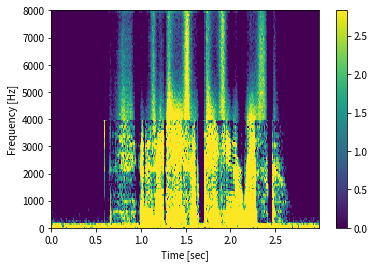

In [30]:
data_number = 42000
pred_show_spectrogram(wav_file_LF[data_number])

### Binary Cross Entropy の定義

In [31]:
class BCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, input, target):
        input = torch.where(torch.isnan(input), torch.zeros_like(input), input)
        input = torch.where(torch.isinf(input), torch.zeros_like(input), input)
        input = torch.where(input>1, torch.ones_like(input), input)  # 1を超える場合には1にする

        target = target.float()

        return self.bce(input, target)

### ハイパーパラメータ

In [32]:
num_epochs = 3
batch_size = 64
bce = BCELoss()
mse = nn.MSELoss()
l1 = nn.L1Loss()
lr = 0.0002
lrG = 10**(-5)
lrD = 1.0 * 10**(-5) # 4.0 * 10**(-5)のがいいかも
beta1 = 0.5

optimizerD = torch.optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))

### GAN の学習

Starting Training Loop...
[1/3][0/2847]	Loss_D: 1.3868	Loss_G: 0.6726	D(x): 0.5104	D(G(z)): 0.5104 / 0.5104


<ipython-input-7-ad242131e573>:58: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(magnitude_spectrogram), vmin=0, vmax=amp)


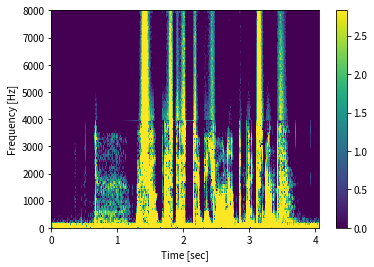

mse: 1.3302959203720093
[1/3][1000/2847]	Loss_D: 1.3600	Loss_G: 0.7295	D(x): 0.5301	D(G(z)): 0.5094 / 0.4854


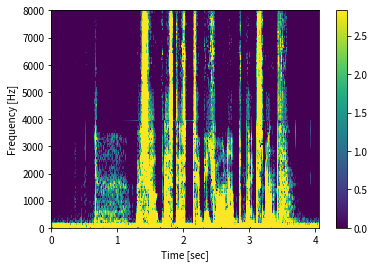

mse: 1.5785409212112427
[1/3][2000/2847]	Loss_D: 1.3384	Loss_G: 0.7203	D(x): 0.5249	D(G(z)): 0.4936 / 0.4902


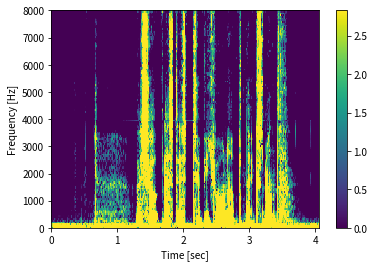

mse: 1.5656557083129883
[2/3][0/2847]	Loss_D: 1.3437	Loss_G: 0.7147	D(x): 0.5147	D(G(z)): 0.4879 / 0.4920


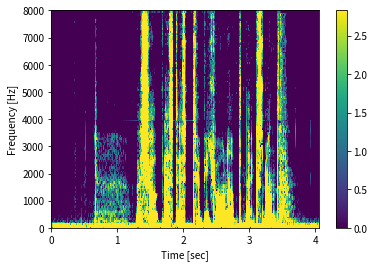

mse: 1.4985311031341553
[2/3][1000/2847]	Loss_D: 1.2609	Loss_G: 0.7638	D(x): 0.5428	D(G(z)): 0.4660 / 0.4721


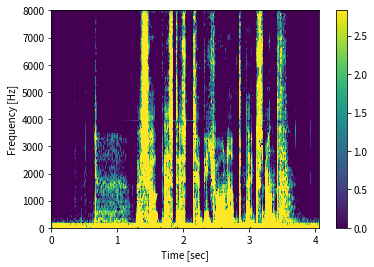

mse: 1.5006612539291382
[2/3][2000/2847]	Loss_D: 1.3264	Loss_G: 0.7156	D(x): 0.5056	D(G(z)): 0.4580 / 0.4974


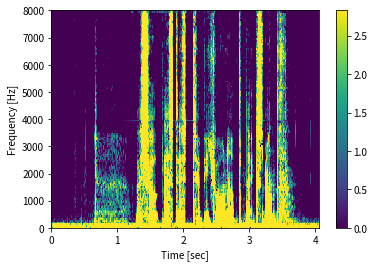

mse: 1.4964947700500488
[3/3][0/2847]	Loss_D: 1.3198	Loss_G: 0.7218	D(x): 0.5217	D(G(z)): 0.4720 / 0.4922


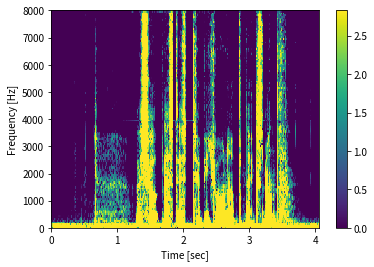

mse: 1.4905813932418823
[3/3][1000/2847]	Loss_D: 1.2528	Loss_G: 0.8096	D(x): 0.5097	D(G(z)): 0.4155 / 0.4545


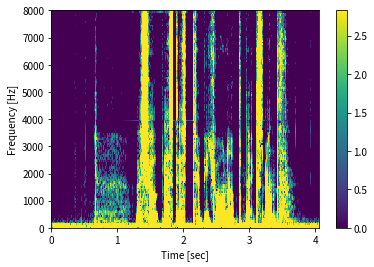

mse: 1.4904412031173706
[3/3][2000/2847]	Loss_D: 1.2795	Loss_G: 0.8492	D(x): 0.5263	D(G(z)): 0.4469 / 0.4380


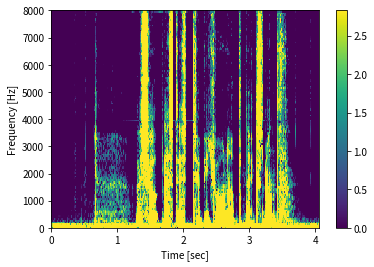

mse: 1.4805828332901


In [33]:
print("Starting Training Loop...")

G_losses = []
D_losses = []
iters = 0
number = 18500 #42000
train_dataloader = DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(dataset_valid, batch_size = batch_size, shuffle = False)

for epoch in range(num_epochs):
    for i, (X, y) in enumerate(train_dataloader):
        ############################
        #  (1) 識別器Dのネットワーク更新: maximize log(D(x)+ log(1 - D(G(z)) )
        ###########################
        ## 本物画像のバッチを使った訓練
        netD.zero_grad()
        # バッチの形式をランタイムに合わせる
        #real_cpu = y #y_train
        label = torch.ones((X.shape[0], 1)).to(device)

        # 本物画像のバッチをDに順伝播させる
        _, output = netD(y) #0か1を予測
        # 全ての本物画像のバッチの損失を計算する
        errD_real = bce(output, label) # 答え合わせ
        # 逆伝播で勾配を計算する
        errD_real.backward(retain_graph=True)
        D_x = output.mean().item()

        ## 偽物画像のバッチを使った訓練
        
        # Gを使って、偽画像のバッチを生成
        fake = netG(X) #低解像度を入力
        label = torch.zeros((X.shape[0], 1)).to(device)
        # Dを使って、全ての偽画像を分類
        _, output = netD(fake) #0か1
        
        # 全ての偽画像に対するDの損失を計算
        errD_fake = bce(output, label)
        # 偽画像に対する勾配を計算
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        
        
        # 全ての本物画像のバッチの勾配と、全ての偽画像のバッチの勾配を足す
        errD = errD_real + errD_fake
        
        
        # Dのパラメータを更新
        optimizerD.step()

        ############################
        # (2) 生成器Gのネットワークを更新: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = torch.ones((X.shape[0], 1)).to(device) #Dが間違えたら損失が減るように
        # ちょうど識別器Dを更新したので、偽画像バッチをもう一度識別器Dに順伝播させる
        fake_features, output = netD(fake)
        real_features, _ = netD(y)
        feature_loss = 0
        for n in range(len(fake_features)):
            feature_loss += l1(fake_features[n], real_features[n])
        # この出力に対するGの損失をもう一度計算
        bce_loss = bce(output, label)
        mse_loss = mse(fake, y)
        errG = 0.2 * bce_loss + 0.2 * mse_loss * (epoch + 1) + (1/len(fake_features)) * feature_loss 
        # Gの勾配を計算
        errG.backward(retain_graph=True)
        D_G_z2 = output.mean().item()
        # Gを更新
        optimizerG.step()
        
        # 訓練のステータスを出力
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_dataloader),
                     errD.item(), bce_loss.item(), D_x, D_G_z1, D_G_z2))
            pred_show_spe(wav_file_LF[number])
            print('mse: {0}'.format(mse_loss.item()))
        # あとでプロットするために損失を保存
        G_losses.append(bce_loss.item())
        D_losses.append(errD.item())
        
        iters += 1

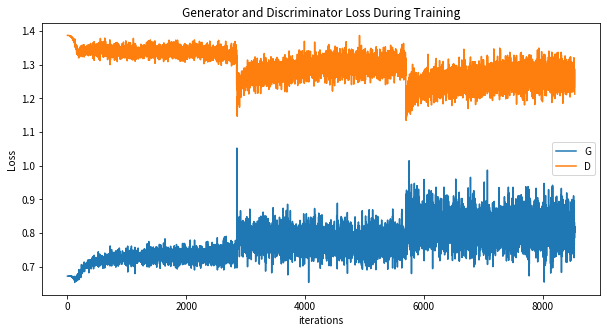

In [34]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 評価データの再構成

In [78]:
#真ん中の予測値をとる.
fs = 16000
netG.eval()
amp = 2 * np.sqrt(2)
pred_spectral=[]
data = LF_magnitude[data_number]
i = 0
sp_size = 129
ur = 2
time_size = 64

pred_sp = []
input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
input_sp = input_sp.unsqueeze(0)
output_sp = netG(input_sp.to(device))
input_sp = input_sp.squeeze().tolist()
output_sp = output_sp.squeeze().tolist()
for j in range(time_size//4):
    sp = input_sp[j] + output_sp[j]
    pred_sp.append(sp)
while i <= len(data)-time_size:
    input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    for j in range(time_size//2):
        sp = input_sp[j+time_size//4] + output_sp[j+time_size//4]
        pred_sp.append(sp)
    i += time_size//2
#最後
for j in range(time_size//4):
    sp = input_sp[j + 3 * time_size//4] + output_sp[j + 3 * time_size//4]
    pred_sp.append(sp)

input_sp = torch.tensor(data)[-time_size:, 0:sp_size//ur]
input_sp = input_sp.unsqueeze(0)
output_sp = netG(input_sp.to(device))
input_sp = input_sp.squeeze().tolist()
output_sp = output_sp.squeeze().tolist()
for i in range(len(data)%(time_size//2)):
    sp = input_sp[time_size - len(data)%(time_size//2) + i] + output_sp[time_size - len(data)%(time_size//2) + i]
    pred_sp.append(sp)
num_pred = np.array(pred_sp)
magnitude_spectrogram = np.exp(num_pred.T) 
spectral_dnn= get_spectral(angle[data_number], magnitude_spectrogram)
spectral_dnn = np.where(np.abs(spectral_dnn) >= amp/10, spectral_dnn, 0)
_, wav_xrec = signal.istft(spectral_dnn, fs, nperseg=256, noverlap=192)
wav_xrec = np.array(wav_xrec, dtype=np.int16) # 戻しておかないとすごい音がする

NameError: name 'time_size' is not defined

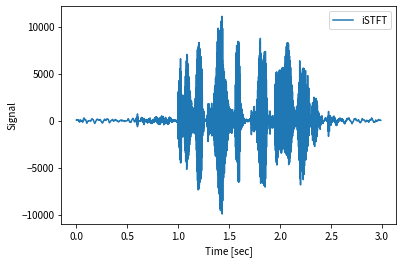

In [175]:
length = len(wav_xrec)
fs = 16000
time = np.arange(length) / float(fs)
plt.plot(time, wav_xrec[:length])
plt.xlabel('Time [sec]')
plt.ylabel('Signal')
plt.legend(['iSTFT'])

plt.show()

### 出力音声

In [176]:
from scipy.io.wavfile import write
write("wav_pred/gan_wav_8to16_2d.wav", 16000, wav_xrec)
import IPython.display
IPython.display.Audio("wav_pred/gan_wav_8to16_2d.wav")

### 正解音声

In [177]:
import IPython.display
IPython.display.Audio(wav_file_HF[number])

### 入力音声

In [178]:
import IPython.display
IPython.display.Audio(wav_file_LF[number])

### 評価データの振幅スペクトログラム

In [179]:
def stft(read_path):
    wave_file = wave.open(read_path, "r")

    amp = 2 * np.sqrt(2)
    length = wave_file.getnframes()
    fs = wave_file.getframerate()
    time = np.arange(length) / float(fs)
    x = wave_file.readframes(wave_file.getnframes())
    wav_x = np.frombuffer(x, dtype= "int16")

    f, t, Zxx = signal.stft(wav_x[:length], fs, nperseg=256, noverlap=192)
    print('フレームレート:{0}'.format(fs))
    plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)
    plt.colorbar()
    plt.title('8000 to 16000')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

フレームレート:16000


<ipython-input-179-79ac554bdecd>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)


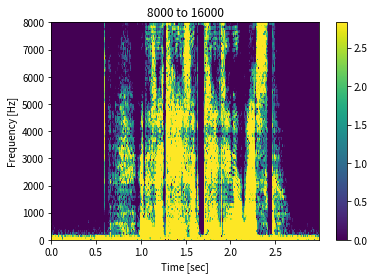

In [180]:
stft('wav_pred/gan_wav_8to16_2d.wav')

フレームレート:16000


<ipython-input-179-79ac554bdecd>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)


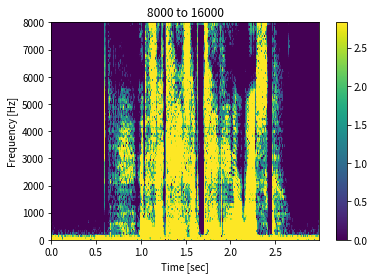

In [181]:
wav_x = stft(wav_file_HF[number])

## 客観的評価指標 (Log Spectrogram Distance) の測定

In [37]:
def LSD(x, y):
    return (1/x.shape[0])*(((1/x.shape[1])*((x-y)**2).sum(axis=1)) ** 0.5).sum()

In [34]:
def pred_spec_2d(time_size, data_num, net, magnitude, angle, wav_m, wav_name):
    #出力の真ん中部分の採用
    net.eval()
    nover = 192
    pred_spectral=[]
    pred_sp = []
    amp = 2 * np.sqrt(2)
    time_size = 64
    sp_size = 129
    lengths = min(len(wav_m[data_num]), len(magnitude[data_num]))
    #print(lengths)
    data = magnitude[data_num][:lengths]
    sp_0 = [1e-10] * sp_size
    
    i = 0
    input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    for j in range(time_size//4):
        if j == 0:
            pred_sp.append(sp_0)
        else:
            sp = input_sp[j] + output_sp[j]
            pred_sp.append(sp)
            
    while i <= len(data)-time_size:
        input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
        input_sp = input_sp.unsqueeze(0)
        output_sp = netG(input_sp.to(device))
        input_sp = input_sp.squeeze().tolist()
        output_sp = output_sp.squeeze().tolist()
        for j in range(time_size//2):
            sp = input_sp[j+time_size//4] + output_sp[j+time_size//4]
            pred_sp.append(sp)
        i += time_size//2
    #最後
    for j in range(time_size//4):
        sp = input_sp[j + 3 * time_size//4] + output_sp[j + 3 * time_size//4]
        pred_sp.append(sp)

    input_sp = torch.tensor(data)[-time_size:, 0:sp_size//ur]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    for i in range(len(data)%(time_size//2)):
        sp = input_sp[time_size - len(data)%(time_size//2) + i] + output_sp[time_size - len(data)%(time_size//2) + i]
        pred_sp.append(sp)

    num_pred = np.array(pred_sp)
    magnitude_spectrogram = np.exp(num_pred.T) 
    
    #LSDの計算
#     input_up = magnitude[data_num][:lengths, sp_size//2:]
#     input_down = magnitude[data_num][:lengths, :sp_size//2]
    
#     lsd_in_label_up = LSD(input_up, wav_m[data_num][:lengths, sp_size//2:])
#     lsd_in_label_down = LSD(input_down, wav_m[data_num][:lengths, :sp_size//2])
#     lsd_out_label_up = LSD(num_pred[:lengths, sp_size//2:], wav_m[data_num][:lengths, sp_size//2:])
#     lsd_out_label_down = LSD(num_pred[:lengths, :sp_size//2], wav_m[data_num][:lengths, :sp_size//2])
    lsd_pre = LSD(num_pred[:lengths], wav_m[data_num][:lengths])
    
    spectral_cnn_2d = get_spectral(angle[data_num][:, :lengths], magnitude_spectrogram)
    spectral_cnn_2d = np.where(np.abs(spectral_cnn_2d) >= amp/10, spectral_cnn_2d, 0)
    _, wav_xrec_2d = signal.istft(spectral_cnn_2d, 16000, nperseg=256, noverlap = nover)
    wav_xrec_2d = np.array(wav_xrec_2d, dtype=np.int16) # 戻しておかないとすごい音がする
    
    _, _, Zxx = signal.stft(wav_xrec_2d, 16000, nperseg = 256, noverlap = nover)
    
    lsd = LSD(np.log(np.abs(Zxx.T)[:lengths] + 10**(-10)), wav_m[data_num][:lengths])

    #print('LSD_in_label_up : {0}, LSD_out_label_up : {1}'.format(lsd_in_label_up, lsd_out_label_up))
    #print('LSD_in_label_down : {0}, LSD_out_label_down : {1}'.format(lsd_in_label_down, lsd_out_label_down))
    
    # write(wav_name, 8000, wav_xrec_2d)
    # return IPython.display.Audio(wav_name)
    return lsd_pre, lsd

In [35]:
i = 0
u_64 = []
for n, data in enumerate(LF_magnitude):
    if len(data) < 64:
        u_64.append(n)
print(u_64)

[]


In [14]:
lsd_pre = 0
lsd = 0
i = 0
for n in range(40698, len(LF_magnitude)):
    i += 1
    if n in u_64:
        continue
    else:
        l_pre, l = pred_spec_2d(time_size = 32, data_num = n, net = netG, magnitude = LF_magnitude, angle = angle, wav_m = HF_magnitude, wav_name = 'a.wav')
        lsd_pre += l_pre
        lsd += l
        if i%500 == 0:
            print(lsd_pre/i, lsd/i)
print('LSD_pre : {0}, LSD : {1}'.format(lsd_pre/i, lsd/i))

## モデルの出力音声の書き出し

In [36]:
def pred_spec_2d_write(time_size, data_num, net, magnitude, angle, wav_m, wav_name):
    #出力の真ん中部分の採用
    net.eval()
    nover = 64
    ur = 2
    pred_spectral=[]
    pred_sp = []
    amp = 2 * np.sqrt(2)
    #time_size = 32
    sp_size = 129
    lengths = min(len(wav_m[data_num]), len(magnitude[data_num]))
    #print(lengths)
    data = magnitude[data_num][:lengths]
    sp_0 = [1e-10] * sp_size
    
    i = 0
    input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    for j in range(time_size//4):
        if j == 0:
            pred_sp.append(sp_0)
        else:
            sp = input_sp[j] + output_sp[j]
            pred_sp.append(sp)
            
    while i <= len(data)-time_size:
        input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
        input_sp = input_sp.unsqueeze(0)
        output_sp = netG(input_sp.to(device))
        input_sp = input_sp.squeeze().tolist()
        output_sp = output_sp.squeeze().tolist()
        for j in range(time_size//2):
            sp = input_sp[j+time_size//4] + output_sp[j+time_size//4]
            pred_sp.append(sp)
        i += time_size//2
    #最後
    for j in range(time_size//4):
        sp = input_sp[j + 3 * time_size//4] + output_sp[j + 3 * time_size//4]
        pred_sp.append(sp)

    input_sp = torch.tensor(data)[-time_size:, 0:sp_size//ur]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    for i in range(len(data)%(time_size//2)):
        sp = input_sp[time_size - len(data)%(time_size//2) + i] + output_sp[time_size - len(data)%(time_size//2) + i]
        pred_sp.append(sp)

    num_pred = np.array(pred_sp)
    magnitude_spectrogram = np.exp(num_pred.T) 
    
    spectral_cnn_2d = get_spectral(angle[data_num][:, :lengths], magnitude_spectrogram)
    spectral_cnn_2d = np.where(np.abs(spectral_cnn_2d) >= amp/10, spectral_cnn_2d, 0)
    _, wav_xrec_2d = signal.istft(spectral_cnn_2d, 16000, nperseg=256, noverlap=nover)
    wav_xrec_2d = np.array(wav_xrec_2d, dtype=np.int16) # 戻しておかないとすごい音がする
    
    write(wav_name, 16000, wav_xrec_2d)
    # return IPython.display.Audio(wav_name)
    # return lsd_pre, lsd

In [57]:
wav_file = sorted(glob.glob('wav_down_16000/*.wav'))[40698:]
for n, data in enumerate(wav_file):
    n += 40698
    if n in u_64:
        continue
    else:
        data = data.replace('wav_down_16000/','')
        pred_spec_2d_write(time_size = 64, data_num = n, net = netG, magnitude = LF_magnitude, angle = angle, wav_m = HF_magnitude, wav_name = 'best_celp_wav_bi_to_16000_celpgan/' + data)
        if n%4000 == 0:
            print(n)
print('end')

44000
end
